In [1]:
using Knet, Images

In [2]:
cd(homedir()*"/PacktPub/Chp10")
include("./KnetJL/mnist.jl")

In [3]:
xtrn,ytrn,xtst,ytst = mnist()
map(summary,(xtrn,ytrn,xtst,ytst))

┌ Info: Loading MNIST...
└ @ Main /Users/malcolm/PacktPub/Chp10/KnetJL/mnist.jl:33


("28×28×1×60000 Array{Float32,4}", "60000-element Array{UInt8,1}", "28×28×1×10000 Array{Float32,4}", "10000-element Array{UInt8,1}")

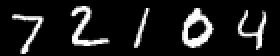

In [4]:
hcat([mnistview(xtst,i) for i=1:5]...)

In [5]:
ytst[1:5]'

1×5 LinearAlgebra.Adjoint{UInt8,Array{UInt8,1}}:
 0x07  0x02  0x01  0x0a  0x04

In [6]:
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
length(dtrn),length(dtst)

(600, 100)

In [7]:
map(summary,first(dtst))

("28×28×1×100 Array{Float32,4}", "100-element Array{UInt8,1}")

In [8]:
# Loss functions
zeroone(w,data,model) = 1 - accuracy(w,data,model)
softmax(w,data,model) = mean(softmax(w,x,y,model) for (x,y) in data)
softmax(w,x,y,model; o...) = nll(model(w,x;o...),y)
softgrad = grad(softmax)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(softmax),Int64,Bool}}) (generic function with 1 method)

In [9]:
# Calculate cross entropy loss of a model with weights w for one minibatch (x,p)
# Use non-zero l1 or l2 for regularization

function softloss(w,x,p,model;l1=0,l2=0,o...)  
    y = model(w,x;o...)
    y = y .- maximum(y,1) # for numerical stability
    expy = exp(y)
    logphat = y .- log(sum(expy,1))
    J = -sum(p .* logphat) / size(x,2)  # dividing by number of instances for per-instance average
    if l1 != 0; J += l1 * sum(sumabs(wi)  for wi in w[1:2:end]); end
    if l2 != 0; J += l2 * sum(sumabs2(wi) for wi in w[1:2:end]); end
    return J
end

function avgloss(w,data,model) # average loss for the whole dataset
    sum = cnt = 0
    for (x,y) in data
        sum += softloss(w,x,y,model)
        cnt += 1
    end
    return sum/cnt
end

avgloss (generic function with 1 method)

In [10]:
function train(w,data,predict; epochs=100,lr=0.1,o...)
    weights = Any[deepcopy(w)]
    for epoch in 1:epochs
        for (x,y) in data
            g = softgrad(w,x,y,predict;o...)
            update!(w,g,lr=lr)  # w[i] = w[i] - lr * g[i]
        end
        push!(weights,deepcopy(w))
    end
    return weights
end

train (generic function with 1 method)

In [11]:
function predict(w,x)
    for i=1:2:length(w)
        x = w[i]*mat(x) .+ w[i+1]
        if i<length(w)-1
            x = relu.(x) # max(0,x)
        end
    end
    return x
end

predict (generic function with 1 method)

In [12]:
function weights(h...; atype=Array{Float32}, winit=0.1)
    w = Any[]
    x = 28*28
    for y in [h..., 10]
        push!(w, convert(atype, winit*randn(y,x)))
        push!(w, convert(atype, zeros(y, 1)))
        x = y
    end
    return w
end

weights (generic function with 1 method)

In [16]:
w = weights(128)

4-element Array{Any,1}:
 Float32[-0.10753 -0.0472574 … -0.0907104 -0.163334; -0.0867709 -0.0067605 … 0.00559417 -0.038552; … ; -0.0509496 0.167307 … -0.0857886 -0.0818476; -0.0958551 -0.000901727 … -0.00360426 -0.0648425]
 Float32[0.0; 0.0; … ; 0.0; 0.0]                                                                                                                                                                     
 Float32[-0.0268088 0.131074 … 0.0701756 0.0138926; 0.0908659 0.131562 … -0.0222316 -0.14402; … ; 0.0694073 0.132391 … 0.153836 -0.0986111; 0.165473 -0.0244121 … 0.260805 -0.201435]                
 Float32[0.0; 0.0; … ; 0.0; 0.0]                                                                                                                                                                     

In [18]:
train(w,dtrn)

MethodError: MethodError: no method matching train(::Array{Any,1}, ::Knet.Data{Tuple{Array{Float32,4},Array{UInt8,1}}})
Closest candidates are:
  train(::Any, ::Any, !Matched::Any; epochs, lr, o...) at In[10]:2

---

In [21]:
pwd()

"/Users/malcolm/PacktPub/Chp10"

In [23]:
include("KnetJL/mnist.jl")

LoadError: MethodError: no method matching installed(::String)
Closest candidates are:
  installed() at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Pkg/src/API.jl:278

---

In [22]:
include("KnetJL/hs.jl")

Main.Housing

In [ ]:
Housing.main("--epochs 20")

---

In [30]:
using DelimitedFiles, Statistics
housefl = "/Users/malcolm/PacktPub/Datasets/housing.data"

function housing(file, test=0)
   data = readdlm(file)'
    # @show size(data) # (14,506)
    x = data[1:13,:]
    y = data[14:14,:]
    x = (x .- mean.(x) ./ std.(x)) # Data normalization
    if test == 0
        xtrn = xtst = x
        ytrn = ytst = y
    else
        r = randperm(size(x,2))          # trn/tst split
        n = round(Int, (1-test) * size(x,2))
        xtrn=x[:,r[1:n]]
        ytrn=y[:,r[1:n]]
        xtst=x[:,r[n+1:end]]
        ytst=y[:,r[n+1:end]]
    end
    return (xtrn, ytrn, xtst, ytst)
end

housing (generic function with 2 methods)

In [31]:
predict(w,x) = (w[1]*x .+ w[2])
loss(w,x,y)  = (sum(abs2, y-predict(w,x)) / size(x,2))
lossgradient = grad(loss)

function train(w, x, y; lr=.1, epochs=20)
    for epoch=1:epochs
        g = lossgradient(w, x, y)
        update!(w, g; lr=lr)
    end
    return w
end

train (generic function with 1 method)

In [32]:
(xtrn, ytrn, xtst, ytst) = housing(housefl)

([NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [24.0 21.6 … 22.0 11.9], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [24.0 21.6 … 22.0 11.9])

In [36]:
xtrn

13×506 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN